We fit a gaussian mixture model to the factor scores of all individuals trying to find the best number of clusters using the BIC

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
import glob

import pylab as plt
from matplotlib.pyplot import get_cmap
%matplotlib inline  

src_dir = os.path.abspath(os.path.join(os.pardir,'src'))
sys.path[0] = src_dir

from analysis.cluster_density import gmm_kd
from analysis.data_sample import get_subset
from analysis.data_sample import data_bootstrap


# Load data and setup

In [2]:
# factor scores
path_read = os.path.join(src_dir,os.pardir,'data_filter')
fname_read = 'ipip300-no0_arr_pd_neoac_score-1.npy'
filename = os.path.join(path_read,fname_read)
arr_pd =  np.load(filename)

# parameters for fitting
n_rep = 10 # number of different initial conditions for optimization
arr_Nc = np.arange(1,10,1) ## range of values for number of clusters

# these are not needed but will be specified
n_rep_kd = 0 # number of randomizations for estaimting density --> not needed here: 0
bw = -1 # bandwidth for density estimation (-1, estimate from avg nearest-neighbor distance)
N_samples = 0 # number of pairs of n.n. for estimating bandwidth --> not needed here:0


In [3]:
#####
# z-score the data in each dimension
#####
N_,D_ = np.shape(arr_pd)
for d in range(D_):
    x_tmp = arr_pd[:,d]
    x_mu = np.mean(x_tmp)
    x_std = np.std(x_tmp)
    arr_pd[:,d] = (x_tmp - x_mu)/x_std

#####
# get a random subset to reduce processing time
# use line above if you want to fit the whole dataset
#####

# arr_x = 1.0*arr_pd#
arr_x = get_subset(arr_pd,1000) 


# Fit

In [4]:
arr_BIC = 0.0*arr_Nc
for i_Nc,Nc in enumerate(arr_Nc):
    print(Nc)
    ## fit the gmm
    dict_result_tmp = gmm_kd(Nc,arr_x,n_rep,n_rep_kd, bw = bw, N_samples = N_samples)
    ## get the BIC
    arr_BIC[i_Nc] = dict_result_tmp['BIC']

1
2
3
4
5
6
7
8
9


In [7]:
## errorbars of the BIC from bootstrapping the dataset 
## note that this is NOT a randomization, 
## we simply draw the same number of respondents with replacement
n_boot = 10 # in the paper we use 100
arr_BIC_boot = np.zeros((n_boot, len(arr_Nc)))

for i_n_boot in range(n_boot):
    arr_x_boot = data_bootstrap(arr_x)
    print('bootstrap sample %s of %s'%(i_n_boot+1,n_boot))
    for i_Nc,Nc in enumerate(arr_Nc):
        ## fit the gmm
        dict_result_tmp = gmm_kd(Nc,arr_x_boot,n_rep,n_rep_kd, bw = bw, N_samples = N_samples)
        ## get the BIC
        arr_BIC_boot[i_n_boot,i_Nc] = dict_result_tmp['BIC']

bootstrap sample 1 of 10
bootstrap sample 2 of 10
bootstrap sample 3 of 10
bootstrap sample 4 of 10
bootstrap sample 5 of 10
bootstrap sample 6 of 10
bootstrap sample 7 of 10
bootstrap sample 8 of 10
bootstrap sample 9 of 10
bootstrap sample 10 of 10


# Plot the result

Text(0,0.5,'BIC')

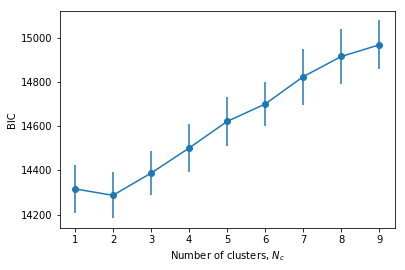

In [9]:
# plt.plot(arr_Nc,arr_BIC,marker='o')
yerr = np.std(arr_BIC_boot,axis=0)
plt.errorbar(arr_Nc,arr_BIC,yerr = yerr, marker='o')

plt.xlabel(r'Number of clusters, $N_c$')
plt.ylabel('BIC')